In [10]:
from benchmark.testsystems import double_well
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
%matplotlib inline

In [11]:
from benchmark.testsystems import NumbaNonequilibriumSimulator
from benchmark.integrators import vvvr_factory, baoab_factory, orvro_factory, aboba_factory

In [12]:
ovrvo = vvvr_factory(double_well.potential, double_well.force, double_well.velocity_scale, double_well.mass)
vrorv = baoab_factory(double_well.potential, double_well.force, double_well.velocity_scale, double_well.mass)
rvovr = aboba_factory(double_well.potential, double_well.force, double_well.velocity_scale, double_well.mass)
orvro = orvro_factory(double_well.potential, double_well.force, double_well.velocity_scale, double_well.mass)

gamma = 10.0
dt = 0.7

In [13]:
x0 = double_well.sample_x_from_equilibrium()
v0 = double_well.sample_v_given_x(x0)

integrators = {'VRORV':vrorv, 'OVRVO': ovrvo, 'ORVRO': orvro, 'RVOVR': rvovr}

def integrate(x0, v0, n_steps, dt=0.6, scheme='VRORV'):
    return integrators[scheme](x0, v0, n_steps, gamma, dt)

x,v = integrate(x0, v0, 1000000, scheme='RVOVR')[:2]
x_baoab,v_baoab = integrate(x0, v0, 1000000, scheme='VRORV')[:2]
x_ovrvo,v_ovrvo = integrate(x0, v0, 1000000, scheme='OVRVO')[:2]
x_orvro,v_orvro = integrate(x0, v0, 1000000, scheme='ORVRO')[:2]

In [14]:
np.vstack([x, v]).T.shape

(1000000, 2)

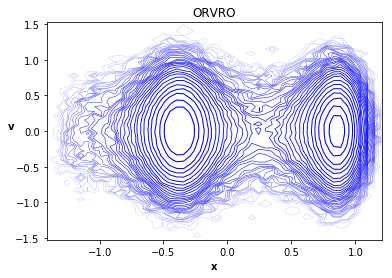

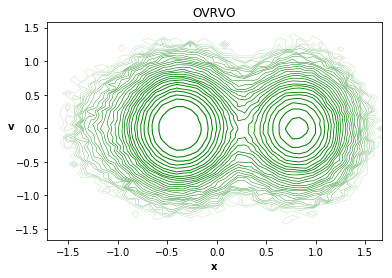

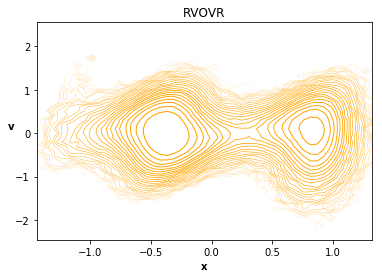

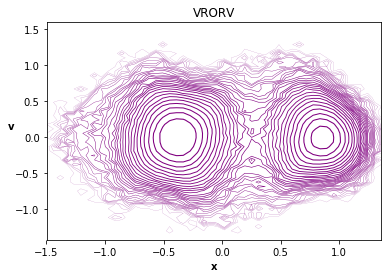

In [15]:
def plot_contours(x,v, color='purple'):
    H, xedges, yedges = np.histogram2d(x,v,bins=50)
    levels = sorted(list(set(sorted(H.flatten())[::int(len(H.flatten()) / 50)])))[1:]
    linewidths = np.linspace(0,1,len(levels)) + 0.1
    plt.contour(H.T,
                extent=(min(xedges), max(xedges), min(yedges), max(yedges)),
                colors=color, levels=levels, linewidths=linewidths)
    plt.xlabel(r'$\mathbf{x}$')
    plt.ylabel(r'$\mathbf{v}$', rotation=0)

plt.figure()
plot_contours(x_orvro, v_orvro, 'blue')
plt.title('ORVRO')

plt.figure()
plot_contours(x_ovrvo, v_ovrvo, 'green')
plt.title('OVRVO')

plt.figure()
plot_contours(x, v, 'orange')
plt.title('RVOVR')

plt.figure()
plot_contours(x_baoab, v_baoab, 'purple')
plt.title('VRORV')

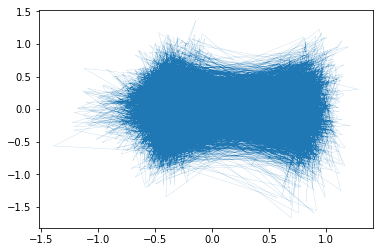

In [16]:
plt.plot(x[::100], v[::100], linewidth=0.1)

In [17]:
# what's the ground-truth density look like
x_grid = np.linspace(-1.75,1.75,1000)
y_grid = np.exp(double_well.log_q(x_grid))

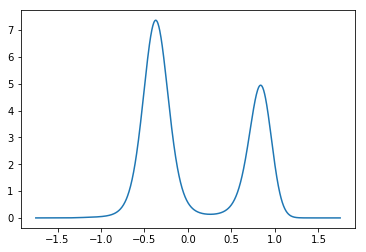

In [18]:
plt.plot(x_grid, y_grid)

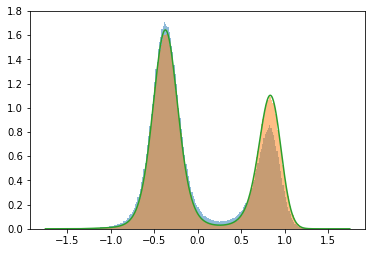

In [19]:
plt.hist(x, bins=200, normed=True, alpha=0.5);
plt.hist(x_baoab, bins=200, normed=True, alpha=0.5);
plt.plot(x_grid, y_grid / np.trapz(y_grid, x_grid))

(-2, 6)

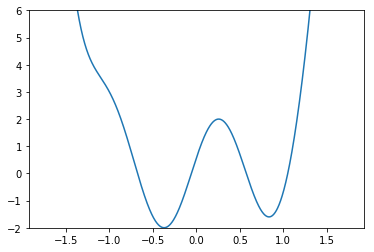

In [20]:
plt.plot(x_grid, double_well.potential(x_grid))
plt.ylim(-2,6)

In [21]:
counts, x2_grid, v2_grid = np.histogram2d(x, v, bins=100)

In [22]:
x_grid = np.linspace(-2.25,2.25,100000)
y_grid = np.exp(double_well.log_q(x_grid))
Z = np.trapz(y_grid, x_grid)
Z

4.4848163908378549

In [23]:
def p(x):
    return np.exp(double_well.log_q(x)) / Z

x_grid = np.linspace(-2,2,10000)
y_grid = p(x_grid)
np.trapz(y_grid, x_grid)

1.0

In [24]:
sigma2 = double_well.velocity_scale**2

def log_v_density(v):
    return -v ** 2 / (2 * sigma2) - np.log((np.sqrt(2 * np.pi * sigma2)))

def v_density(v):
    return np.exp(log_v_density(v))

In [25]:
def integrate_on_grid(grid, p, n_trapz_bins=1000):
    exact_hist = np.zeros(len(grid) - 1)
    for i, (left, right) in enumerate(zip(grid[:-1], grid[1:])):
        
        trapz_grid = np.linspace(left, right, n_trapz_bins)
        y = p(trapz_grid)
        exact_hist[i] = np.trapz(y, trapz_grid)
    return exact_hist

exact_hist_x = integrate_on_grid(x2_grid, p)
exact_hist_v = integrate_on_grid(v2_grid, v_density)

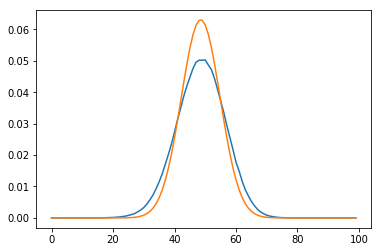

In [26]:
plt.plot(counts.sum(0) / np.sum(counts))
plt.plot(exact_hist_v)

In [27]:
hist_density = counts / np.sum(counts)

In [28]:
rho_x = hist_density.sum(1)
pi_x = exact_hist_x

In [29]:
x_grid = (x2_grid[1:] + x2_grid[:-1])/2
v_grid = (v2_grid[1:] + v2_grid[:-1])/2

In [30]:
def plot_rho_x_diff(rho_x, color='blue', scheme=None, ax=None):

    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    plt.plot(x_grid, pi_x, color='grey', label='equilibrium')
    plt.plot(x_grid, rho_x, color=color, linestyle='--', label=scheme)
    
    fill_alpha = 0.2
    
    # rho(x) > pi(x)
    plt.fill_between(x_grid, rho_x, pi_x, where=(rho_x > pi_x), alpha=fill_alpha, color=color, hatch='///')
    
    # rho(x) < pi(x)
    plt.fill_between(x_grid, rho_x, pi_x, where=(rho_x < pi_x), alpha=fill_alpha, color=color)
    
    x_ticks = [-1,0,1]
    plt.xticks(x_ticks, map(str, x_ticks))
    
    plt.yticks([])
    plt.xlabel(r'$x$')
    
    plt.ylim(0,)

In [31]:
def get_density(scheme, dt=0.5, n_samples=10000000):
    
    x, v = integrate(x0, v0, n_samples, dt=dt, scheme=scheme)[:2]
    
    n_skip = 1000
    x, v = x[n_skip:], v[n_skip:]
    
    counts = np.histogram2d(x, v, bins=(x2_grid, v2_grid))[0]
    
    rho = counts / np.sum(counts)
    
    return rho

In [32]:
sum([np.ones((10,10))] * 10)

array([[ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.]])

In [47]:
from tqdm import tqdm
dts = np.linspace(0.1,0.70)

n_replicates = 10

schemes = ['OVRVO', 'ORVRO', 'VRORV', 'RVOVR']
def get_rhos(scheme='OVRVO'):
    rhos = []
    for dt in tqdm(dts):
        rho = sum([get_density(scheme, dt) for _ in range(n_replicates)]) / n_replicates
        rhos.append(rho)
    rho_xs = [rho.sum(1) for rho in rhos]
    return rhos, rho_xs

all_rhos = dict()
for scheme in schemes:
    all_rhos[scheme] = get_rhos(scheme)

 86%|████████▌ | 43/50 [20:59<03:27, 29.64s/it]/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
 98%|█████████▊| 49/50 [23:51<00:28, 28.49s/it]/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return getattr(obj, method)(*args, **kwds)
100%|██████████| 50/50 [20:42<00:00, 23.17s/it]


In [48]:
exact_hist_xv = np.outer(exact_hist_x, exact_hist_v)

In [49]:
all_rhos['equilibrium'] = exact_hist_xv

In [50]:
from pickle import dump

with open('all_rhos.pkl', 'wb') as f:
    dump(all_rhos, f)

In [51]:
# only plot a few dts
dts_ = dts[::8]
dts_

array([ 0.1       ,  0.19795918,  0.29591837,  0.39387755,  0.49183673,
        0.58979592,  0.6877551 ])

In [52]:
import seaborn.apionly as sns
schemes = sorted(['RVOVR', 'VRORV', 'OVRVO', 'ORVRO'])
colors = dict(zip(schemes, ['Blues', 'Greens', 'Oranges', 'Purples']))

colormaps = dict()

for scheme in schemes:
    colormap = sns.color_palette(colors[scheme], n_colors=len(dts))
    colormaps[scheme] = dict(zip(dts, colormap))
    
dt_ = sorted(dts)[int(len(dts) / 2)]
half_depth_colors = dict()
for scheme in schemes:
    half_depth_colors[scheme] = colormaps[scheme][dt_]

In [53]:
colors

{'ORVRO': 'Blues', 'OVRVO': 'Greens', 'RVOVR': 'Oranges', 'VRORV': 'Purples'}

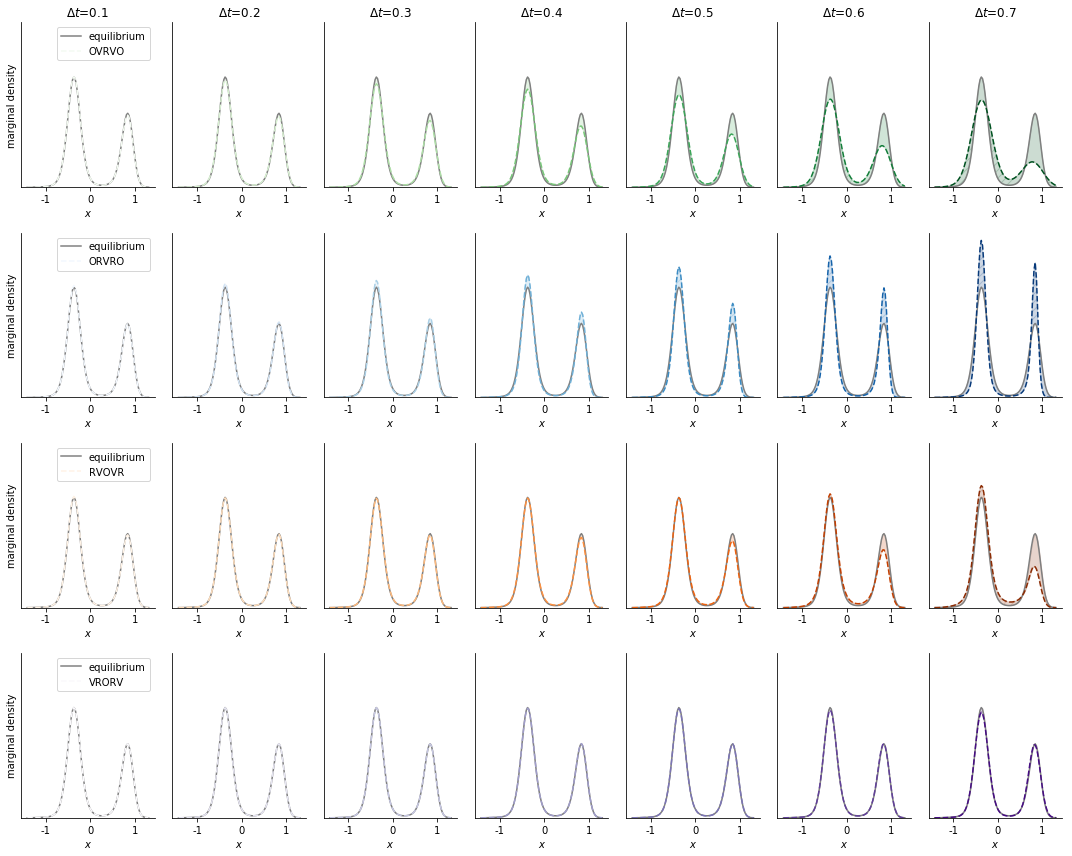

In [54]:
index = 1
scale_factor = 3
plt.figure(figsize=(5*scale_factor, 4 * scale_factor))
ax = None

first = True
for i in range(len(dts))[::8]:
    scheme = 'OVRVO'
    rho_xs = all_rhos[scheme][1]
    
    ax = plt.subplot(4, len(dts_), index, sharey=ax)
    plot_rho_x_diff(rho_xs[i], ax=ax, scheme=scheme, color=colormaps[scheme][dts[i]])
    if first:
        plt.ylabel('marginal density')
        plt.legend(loc='best')
    index += 1
    first = False
    plt.title(r'$\Delta t$='+'{:.1f}'.format(dts[i]))

first = True
for i in range(len(dts))[::8]:
    scheme = 'ORVRO'
    rho_xs = all_rhos[scheme][1]
    
    ax = plt.subplot(4, len(dts_), index, sharey=ax)
    plot_rho_x_diff(rho_xs[i], ax=ax, scheme=scheme, color=colormaps[scheme][dts[i]])
    if first:
        plt.ylabel('marginal density')
        plt.legend(loc='best')
    index += 1
    first = False
    
first = True
for i in range(len(dts))[::8]:
    
    scheme = 'RVOVR'
    rho_xs = all_rhos[scheme][1]
    
    ax = plt.subplot(4, len(dts_), index, sharey=ax)
    plot_rho_x_diff(rho_xs[i], ax=ax, scheme=scheme, color=colormaps[scheme][dts[i]])
    if first:
        plt.ylabel('marginal density')
        plt.legend(loc='best')
    index += 1
    first = False
first = True
for i in range(len(dts))[::8]:
    scheme = 'VRORV'
    rho_xs = all_rhos[scheme][1]
    
    ax = plt.subplot(4, len(dts_), index, sharey=ax)
    
    plot_rho_x_diff(rho_xs[i], ax=ax, scheme=scheme, color=colormaps[scheme][dts[i]])
    if first:
        plt.ylabel('marginal density')
        plt.legend(loc='best')
    index += 1
    first = False

plt.tight_layout()

plt.savefig('everything_on_grid.jpg', bbox_inches='tight', dpi=300)
plt.savefig('everything_on_grid.pdf')

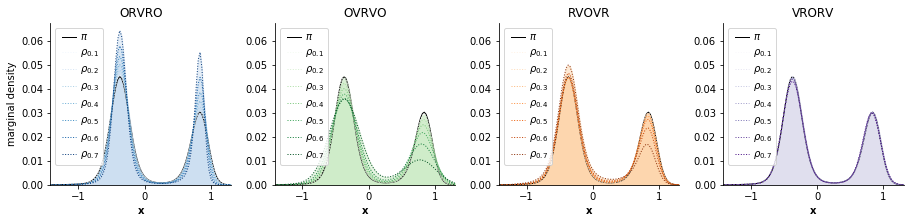

In [70]:
def plot_scheme(scheme, ax=None):
    
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    linestyle_pi='solid'
    linestyle_rho='dotted'
    
    linewidth = 1
    
    plt.plot(x_grid, pi_x, color='black',
             linestyle=linestyle_pi, label=r'$\pi$', linewidth=linewidth)
    
    for i in range(len(dts))[::8]:
        rho_x = all_rhos[scheme][1][i]

        plt.plot(x_grid, rho_x, color=colormaps[scheme][dts[i]], linewidth=linewidth,
                 linestyle=linestyle_rho, label=r'$\rho_{' + '{:.1f}'.format(dts[i]) + r'}$')

        plt.fill_between(x_grid, rho_x, color=colormaps[scheme][dts[10]], alpha=0.5)
        
        plt.xlabel('$\mathbf{x}$')
    plt.legend(loc='upper left', numpoints=5, handletextpad=0.1)
    plt.ylim(0,)
    plt.xlim(min(x_grid), max(x_grid))
    plt.xticks([-1,0,1])
        
i = 1
ax = None

scale_factor = 3.2
plt.figure(figsize=(4 * scale_factor, 1 * scale_factor))

for scheme in sorted(schemes):
    ax = plt.subplot(1,4,i, sharey=ax)
    
    if i == 1:
        plt.ylabel('marginal density')
    
    plt.title(scheme)
    plot_scheme(scheme, ax)
    
    i += 1
plt.tight_layout()
plt.savefig('collapsed.jpg', dpi=300, bbox_inches='tight')
plt.savefig('collapsed.pdf', bbox_inches='tight')

In [57]:
from scipy.stats import entropy

entropy(rho_x, pi_x)

0.022611476923133433

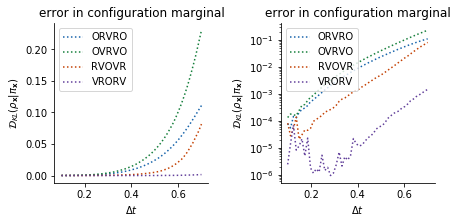

In [58]:
def plot_conf_summary(ax=None):

    for scheme in sorted(schemes):
        plt.plot(dts, [entropy(rho_x, pi_x) for rho_x in all_rhos[scheme][1]],
                 color=colormaps[scheme][dts[-10]],
                 linestyle='dotted', label=scheme,
                )
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    plt.xlabel(r'$\Delta t$')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho_{\mathbf{x}} \| \pi_{\mathbf{x}})$')
    
    plt.legend(loc='upper left')
    plt.title('error in configuration marginal')

scale_factor = 3.2

plt.figure(figsize=(2 * scale_factor, 1 * scale_factor))

# linear scale
ax = plt.subplot(1,2,1)
plot_conf_summary(ax)


# log scale
ax = plt.subplot(1,2,2)
plot_conf_summary(ax)
plt.yscale('log')

plt.tight_layout()

plt.savefig('conf_summary.jpg', dpi=300, bbox_inches='tight')

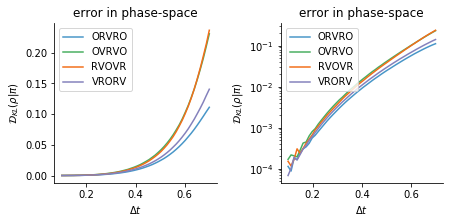

In [59]:
def plot_phase_space_summary(ax=None):

    for scheme in sorted(schemes):
        plt.plot(dts, [entropy(rho.flatten(), exact_hist_xv.flatten()) for rho in all_rhos[scheme][0]],
                 color=colormaps[scheme][dts[-20]],
                 linestyle='solid', label=scheme,
                )
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    plt.xlabel(r'$\Delta t$')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho \| \pi)$')
    
    plt.legend(loc='upper left')
    plt.title('error in phase-space')

scale_factor = 3.2

plt.figure(figsize=(2 * scale_factor, 1 * scale_factor))

# linear scale
ax = plt.subplot(1,2,1)
plot_phase_space_summary(ax)


# log scale
ax = plt.subplot(1,2,2)
plot_phase_space_summary(ax)
plt.yscale('log')

plt.tight_layout()

plt.savefig('phase_space_summary.jpg', dpi=300, bbox_inches='tight')

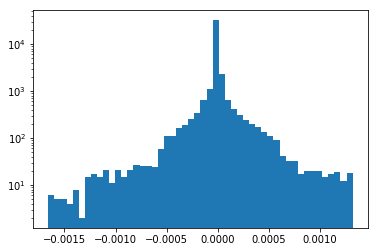

In [60]:
differences = []
for scheme in sorted(schemes):
    difference = (exact_hist_xv - all_rhos[scheme][0][-1]).T
    differences.append(difference)
    
all_differences = np.hstack([d.flatten() for d in differences])
plt.hist(all_differences, bins=50);
plt.yscale('log')

In [65]:
version_counter = 0

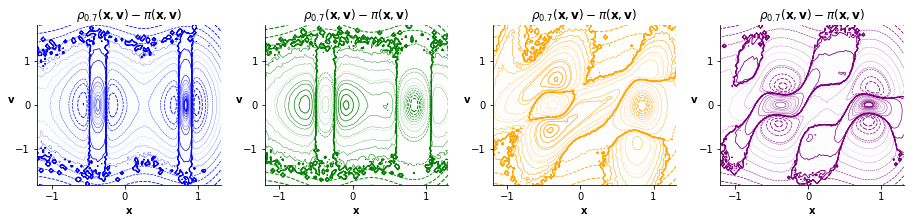

In [69]:
scale_factor = 3.2
plt.figure(figsize=(4*scale_factor,1*scale_factor))
n_levels = 15
#levels = np.linspace(-0.0001,0.0001, n_levels)
#levels = sorted(all_differences)[::int(len(all_differences) / n_levels)]
linewidths = np.abs(np.linspace(-1,1,n_levels)) + 0.1



def plot_contours_scheme(scheme='RVOVR', ax=None):
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    rho = all_rhos[scheme][0][-1]
    extent=(min(x_grid), max(x_grid), min(v_grid), max(v_grid))
    
    # if you want to plot kl integrand
    #rho_reg = (0.00001 + rho)
    #rho_reg /= np.sum(rho)
    #difference = - np.log((rho_reg / exact_hist_xv).T)
    #title = r'$\log \left( \frac{\rho(\mathbf{x}, \mathbf{v})}{\pi(\mathbf{x}, \mathbf{v})} \right)$'
    
    
    # if you want to plot the densities subtracted from each other
    difference = (rho - exact_hist_xv).T
    title = r'$\rho_{0.7}(\mathbf{x}, \mathbf{v}) - \pi(\mathbf{x}, \mathbf{v})$'
    
    
    levels = sorted(difference.flatten())[::int(len(difference.flatten()) / n_levels)]
    levels.extend(list(np.linspace(np.min(difference), np.max(difference), n_levels)))
    levels = sorted(list(set(levels)))
    
    # playing around with where to put the contours...
    #levels = np.linspace(np.min(difference), np.max(difference), n_levels)
    
    plt.contour(difference,
                colors=colors[scheme][:-1],
                levels=levels,
                linewidths=linewidths,
                extent=extent
               )
    
    plt.contourf(difference, cmap=colors[scheme] + '_r', levels=levels,extent=extent,alpha=0.01)

    plt.xlim(-1.2,max(x_grid))
    plt.ylim(-1.8,1.8)

    plt.title(title)
    
    plt.yticks([-1,0,1])
    plt.xticks([-1,0,1])
    plt.xlabel(r'$\mathbf{x}$')
    plt.ylabel(r'$\mathbf{v}$',rotation=0)
    
    



i = 1
ax = None
for scheme in sorted(schemes):
    ax = plt.subplot(1,4,i)
    plot_contours_scheme(scheme, ax)
    i += 1
    
    
    
version_counter += 1

plt.tight_layout()
plt.savefig('contours_v{}.jpg'.format(version_counter), bbox_inches='tight', dpi=300)

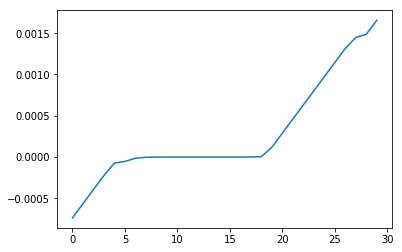

In [67]:
plt.plot(levels)

In [ ]:
# putting it all together!

# 2 rows: configuration, and full phase-space
# 5 columns: (summary, ORVRO, OVRVO, RVOVR, VRORV)

# currently just clicking and dragging it around in keynote, but once we settle on how this is supposed to look,
# I'll generate the whole thing altogether

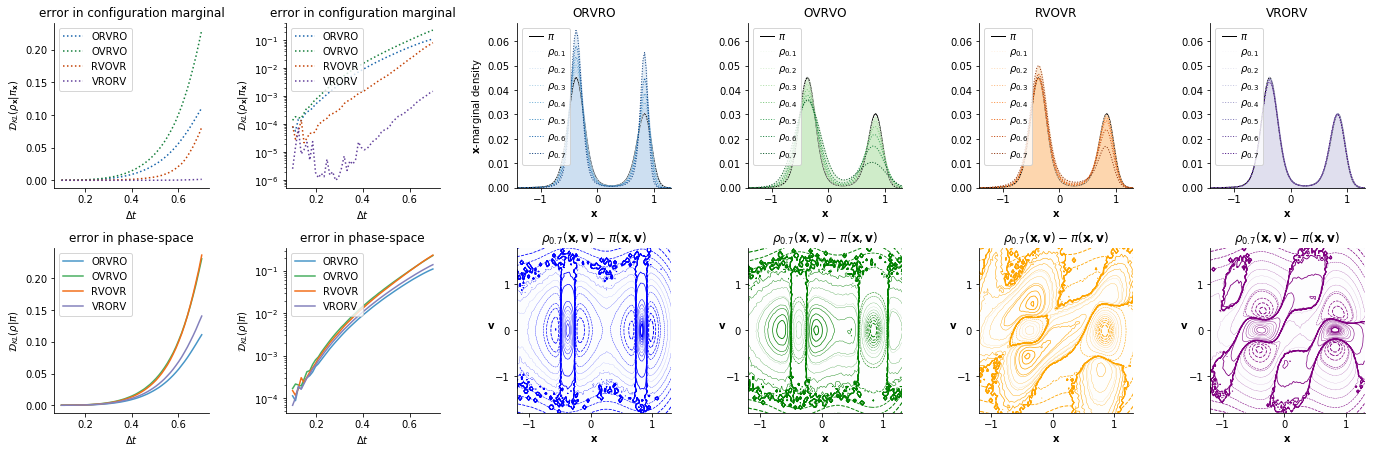

In [74]:
scale_factor = 3.2


n_rows = 2
n_cols = 6
plt.figure(figsize=(n_cols * scale_factor, n_rows * scale_factor))

index = 1

# linear scale conf summary
ax = plt.subplot(n_rows, n_cols, index)
plot_conf_summary(ax)
index += 1

# log scale conf summary
ax = plt.subplot(n_rows, n_cols, index)
plot_conf_summary(ax)
plt.yscale('log')
index += 1


# conf plots
ax = None

for scheme in sorted(schemes):
    ax = plt.subplot(n_rows, n_cols,index, sharey=ax)
    
    # only put a y-label on the left-most one
    if scheme == sorted(schemes)[0]:
        plt.ylabel('$\mathbf{x}$-marginal density')
        
    plt.title(scheme)
    plot_scheme(scheme)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    index += 1
    
# linear scale phase-space summary
ax = plt.subplot(n_rows, n_cols, index)
plot_phase_space_summary(ax)
index += 1

# log scale phase-space summary
ax = plt.subplot(n_rows, n_cols, index)
plot_phase_space_summary(ax)
plt.yscale('log')
index += 1

# phase-space contour plots
ax = None
for scheme in sorted(schemes):
    ax = plt.subplot(n_rows, n_cols, index, sharey=ax)
        
    plt.title(scheme)
    plot_contours_scheme(scheme, ax=ax)
    index += 1

plt.tight_layout()
plt.savefig('fig1_draft.pdf', bbox_inches='tight')